In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROSHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [97]:
train_data = pd.read_csv('train_data.txt', sep=':::', header=None, names=['ID', 'Title', 'Genre', 'Description'], engine='python')
test_data = pd.read_csv('test_data.txt', sep=':::', header=None, names=['ID', 'Title', 'Description'], engine='python')


In [40]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


In [41]:
train_data['Genre'].unique()

array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
       ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
       ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
       ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
       ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
       ' musical ', ' war '], dtype=object)

In [98]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    return text

train_data['Description'] = train_data['Description'].apply(clean_text)
test_data['Description'] = test_data['Description'].apply(clean_text)


In [99]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

train_data['Description'] = train_data['Description'].apply(preprocess_text)
test_data['Description'] = test_data['Description'].apply(preprocess_text)



In [44]:
print(train_data.head())


   ID                               Title       Genre                                        Description
0   1       Oscar et la dame rose (2009)       drama   listening in to a conversation between his doc...
1   2                       Cupid (1997)    thriller   a brother and sister with a past incestuous re...
2   3   Young, Wild and Wonderful (1980)       adult   as the bus empties the students for their fiel...
3   4              The Secret Sin (1915)       drama   to help their unemployed father make ends meet...
4   5             The Unrecovered (2007)       drama   the films title refers not only to the unrecov...


In [45]:
train_data['original_length'] = train_data['Description'].apply(len)
train_data['cleaned_length'] = train_data['Description'].apply(preprocess_text).apply(len)

print("Average length before cleaning:", train_data['original_length'].mean())
print("Average length after cleaning:", train_data['cleaned_length'].mean())


Average length before cleaning: 580.9435754602132
Average length after cleaning: 580.9435754602132


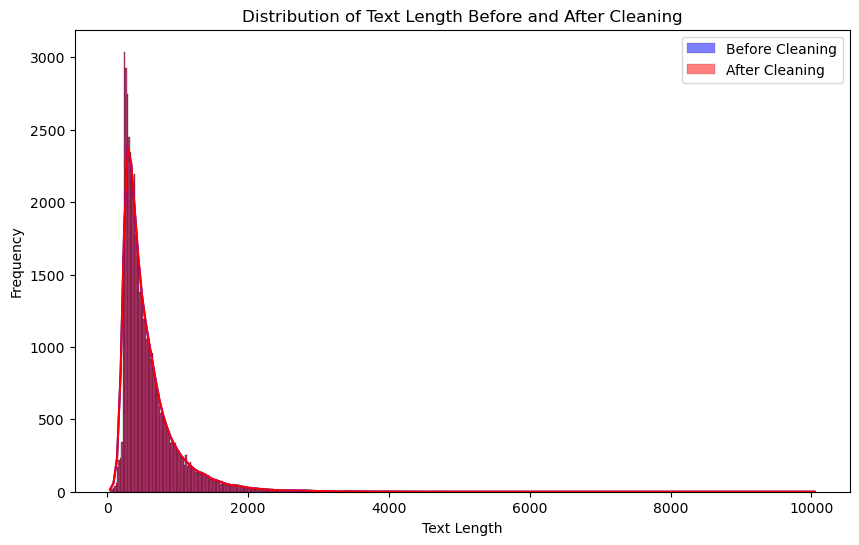

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['original_length'], color='blue', label='Before Cleaning', kde=True)
sns.histplot(train_data['cleaned_length'], color='red', label='After Cleaning', kde=True)
plt.legend()
plt.title('Distribution of Text Length Before and After Cleaning')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


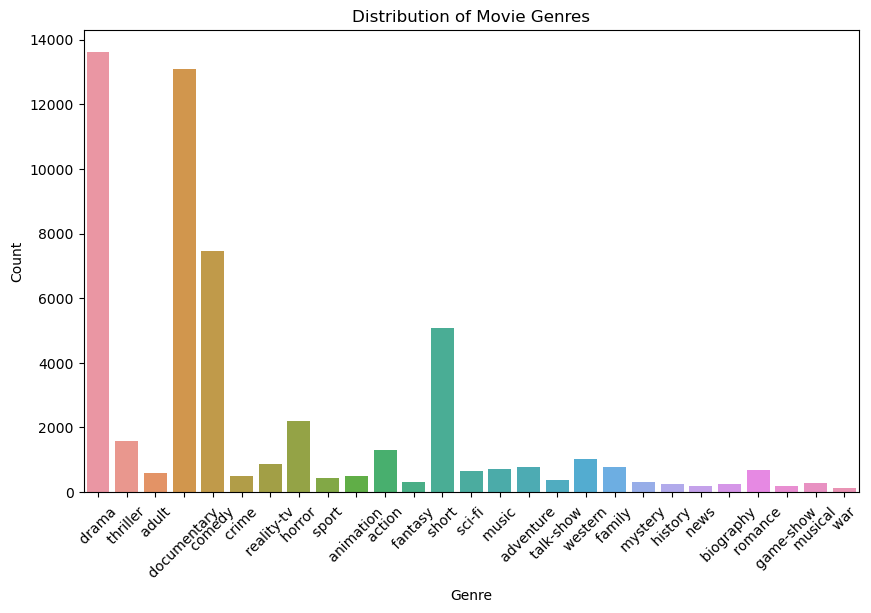

In [100]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='Genre')
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [101]:

from sklearn.utils import shuffle

# Load your train data
# Define the majority and minority classes
majority_classes = train_data[train_data['Genre'].isin([' drama ', ' documentary '])]
minority_classes = train_data[~train_data['Genre'].isin([' drama ', ' documentary '])]

In [126]:
# Determine the minimum size for downsampling
desired_count = 8000

# Downsample the majority classes
majority_classes_downsampled = []
for genre in [' drama ', ' documentary ']:
    subset = majority_classes[majority_classes['Genre'] == genre]
    downsampled_subset = subset.sample(n=desired_count, random_state=42)
    majority_classes_downsampled.append(downsampled_subset)

In [127]:
downsampled_train_data = pd.concat([minority_classes] + majority_classes_downsampled)

# Shuffle the combined dataset
downsampled_train_data = shuffle(downsampled_train_data, random_state=42).reset_index(drop=True)

# Verify the number of rows after downsampling
print(f"Number of rows before downsampling: {len(train_data)}")
print(f"Number of rows after downsampling: {len(downsampled_train_data)}")

Number of rows before downsampling: 54214
Number of rows after downsampling: 43505


In [128]:
# Extract features and labels
X_train = downsampled_train_data['Description']
y_train = downsampled_train_data['Genre']

# Display the number of rows in X_train to ensure it's correct
print(f"Number of rows in X_train after downsampling: {len(X_train)}")
print(f"Number of rows in y_train after downsampling: {len(y_train)}")

Number of rows in X_train after downsampling: 43505
Number of rows in y_train after downsampling: 43505


In [129]:
downsampled_train_data.shape

(43505, 4)

In [130]:

tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X_train = tfidf_vectorizer.fit_transform(X_train)

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [131]:
X_train.shape

(43505, 128959)

In [132]:
y_train.shape

(43505,)

In [133]:
X_test = tfidf_vectorizer.transform(test_data['Description'])

In [134]:
X_test.shape


(54200, 128959)

In [135]:
test_data_solution = pd.read_csv('test_data_solution.txt', sep=':::', header=None, names=['ID', 'Title', 'Genre', 'Description'], engine='python')
y_test = test_data_solution['Genre']

In [136]:
y_test

0            thriller 
1              comedy 
2         documentary 
3               drama 
4               drama 
             ...      
54195          horror 
54196         western 
54197           adult 
54198           drama 
54199           drama 
Name: Genre, Length: 54200, dtype: object

In [137]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [138]:
lr_predictions = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_predictions))
print("Logistic Regression Classification Report:\n", classification_report(y_test, lr_predictions))

Logistic Regression Accuracy: 0.5881365313653136


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression Classification Report:
                precision    recall  f1-score   support

      action        0.49      0.30      0.38      1314
       adult        0.61      0.22      0.32       590
   adventure        0.69      0.16      0.26       775
   animation        0.62      0.03      0.06       498
   biography        0.00      0.00      0.00       264
      comedy        0.48      0.71      0.57      7446
       crime        0.41      0.02      0.04       505
 documentary        0.69      0.84      0.76     13096
       drama        0.59      0.69      0.64     13612
      family        0.52      0.08      0.14       783
     fantasy        0.75      0.02      0.04       322
   game-show        0.92      0.47      0.62       193
     history        0.00      0.00      0.00       243
      horror        0.64      0.61      0.63      2204
       music        0.65      0.47      0.54       731
     musical        0.33      0.01      0.01       276
     mystery        

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [139]:
lr_predictions



array([' comedy ', ' drama ', ' documentary ', ..., ' comedy ', ' drama ',
       ' documentary '], dtype=object)

In [140]:
y_test

0            thriller 
1              comedy 
2         documentary 
3               drama 
4               drama 
             ...      
54195          horror 
54196         western 
54197           adult 
54198           drama 
54199           drama 
Name: Genre, Length: 54200, dtype: object

In [141]:
# # or
# import joblib  # For newer versions of scikit-learn

# # Save the model
# joblib.dump(lr_model, 'movie_genre_classifie_2.joblib')



In [142]:
# # Load the model
# loaded_model = joblib.load('movie_genre_classifier_2.joblib')

# # Use the loaded model to make predictions
# predictions = loaded_model.predict(X_test[2])

In [143]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [144]:
lr_model.classes_

array([' action ', ' adult ', ' adventure ', ' animation ', ' biography ',
       ' comedy ', ' crime ', ' documentary ', ' drama ', ' family ',
       ' fantasy ', ' game-show ', ' history ', ' horror ', ' music ',
       ' musical ', ' mystery ', ' news ', ' reality-tv ', ' romance ',
       ' sci-fi ', ' short ', ' sport ', ' talk-show ', ' thriller ',
       ' war ', ' western '], dtype=object)

In [145]:
cm = confusion_matrix(y_test, lr_predictions, labels=lr_model.classes_)


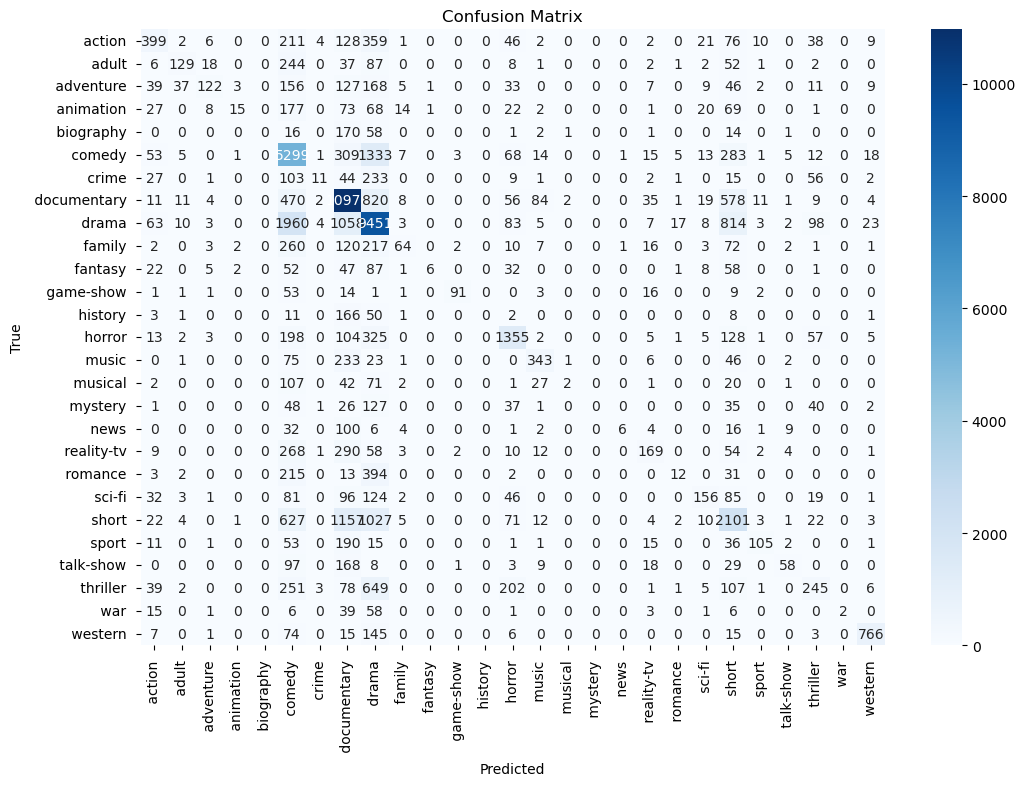

In [150]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [147]:
report = classification_report(y_test, lr_predictions, target_names=lr_model.classes_)
print(report)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      action        0.49      0.30      0.38      1314
       adult        0.61      0.22      0.32       590
   adventure        0.69      0.16      0.26       775
   animation        0.62      0.03      0.06       498
   biography        0.00      0.00      0.00       264
      comedy        0.48      0.71      0.57      7446
       crime        0.41      0.02      0.04       505
 documentary        0.69      0.84      0.76     13096
       drama        0.59      0.69      0.64     13612
      family        0.52      0.08      0.14       783
     fantasy        0.75      0.02      0.04       322
   game-show        0.92      0.47      0.62       193
     history        0.00      0.00      0.00       243
      horror        0.64      0.61      0.63      2204
       music        0.65      0.47      0.54       731
     musical        0.33      0.01      0.01       276
     mystery        0.00      0.00      0.00       318
        n

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
